# Convolutional Neural Network:
### Color Fundus Photograph Region of Interest --> 58-point VF sensitivity prediction

In [25]:
# import modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image, ImageOps
from scipy.interpolate import Rbf

### This Notebook documents efforts to develop, optimize and evaluate a CNN trained on color fundus photograph regions of interest (ROIs) for multi-regression prediction of 58 visual field (VF) sensitivity values.

#### Approach:<br>
- 3-convolutional layers for feature learning + 2-dense layers for multi-output regression

#### Rationale:<br>
- **Goal: structure-->function mapping**<br>
- A model that can predict VF sensitivity points (functional assessment of vision) from retinal imaging may support glaucoma progression monitoring or risk assessment without routine VF testing at every eye exam visit, especially valuable in settings where access to VF optimetry resources are limited or unavailable.

#### Contents:<br>
**Exploratory Data Analysis**
- Analysis of Available Images
- Visual Field & Associated Clinical Data Import
- Initial Assessment of IOP and VF Data Points (blind spots dropped)
- Initial Functions for Image Processing, VF Interpolation & Visualization
- Exploration of left eye (OS), right eye (OD) image availability across patients
- EDA: Image count assessments

**Convolutional Neural Network**
- Finalized CNN
- Parameter Sweep Effort
- CNN Model Evaluation
- Archived preliminary CNN activities

# Exploratory Data Analysis

#### Exploratory Analysis of Available Images

In [ ]:
# initial paths for local processing
# os.getcwd()
# change working directory to data directory containing ROI images
# os.chdir("ROI images")

In [5]:
# directories relative to GitHub repository file
os.chdir("ROIs")

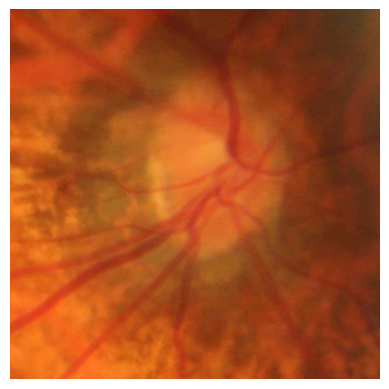

(453, 453, 3)


In [6]:
# sample images
img_path = "1_OD_1.jpg"  # subject 1, visit 1, right eye (OD)

img = mpimg.imread(img_path)

plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.show()

print(img.shape)

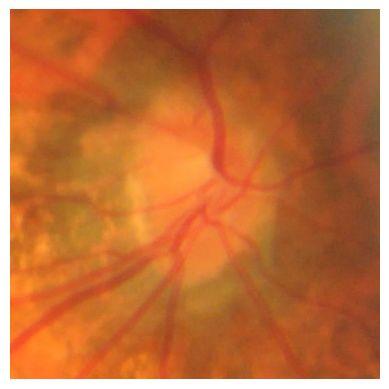

(565, 565, 3)


In [7]:
img_path = "1_OD_2.jpg"  # subject 1, visit 2, right eye (OD)

img = mpimg.imread(img_path)

plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.show()
print(img.shape)

In [8]:
# an alternative approach could use the entire color fundus photograph (CFP) for training input
os.chdir("../CFPs")

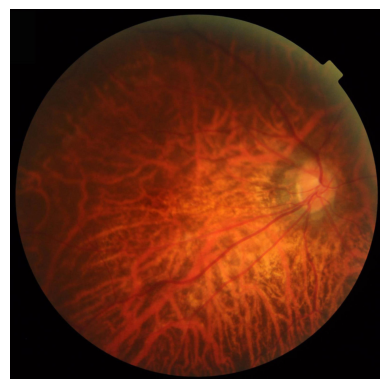

(1556, 1556, 3)


In [9]:
img_path = "1_OD_1.jpg"

img = mpimg.imread(img_path)

plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.show()

print(img.shape)

In [ ]:
# Using the full CFP would require cropping to the circular region and removing black padding
# one approach: consider cropping based on an adaptive radius from the image center
# (adapative here means responsive to image dimensions)

import cv2

def crop_cfp(image):

    img = cv2.imread(image)
    
    center_x = img.shape[1] // 2 
    center_y = img.shape[0] // 2
    radius = int(center_y * 0.94) # adaptive radius
        
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    cv2.circle(mask, (center_x, center_y), radius, 255, -1)  # white filled circle
    
    # use alpha channel for transparency
    circular_crop = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    circular_crop[:, :, 3] = mask  # alpha channel = mask
    
    x1 = max(center_x - radius, 0)
    y1 = max(center_y - radius, 0)
    x2 = min(center_x + radius, img.shape[1])
    y2 = min(center_y + radius, img.shape[0])
    cropped = circular_crop[y1:y2, x1:x2]

    cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGRA2RGB)
    image_output = Image.fromarray(cropped_rgb)
    
    return image_output

In [10]:
# we will focus on the ROIs
os.chdir("../ROIs")

#### Visual Field and Associated Clinical Data Import

In [11]:
# local working paths
# get associated data for each subject
# initial visit data
# GRAPE_df = pd.read_excel("../GRAPE_Glaucoma_Dataset/VF and clinical information.xlsx", header=0)
# initial visit data with all follow-ups, focus on VF data
# GRAPE_followup_df = pd.read_csv("../UW_and_GRAPE_data/GRAPE_FollowUps.csv", header=0)

In [11]:
# GitHub paths
# get associated data for each subject
# initial visit data
GRAPE_df = pd.read_csv("../data/GRAPE_VF.csv", header=0)
# initial visit data with all follow-ups, focus on VF data
GRAPE_followup_df = pd.read_csv("../data/GRAPE_FollowUps.csv", header=0)

In [12]:
GRAPE_df.head()

,Subject Number,Laterality,Age,Gender,IOP,CCT,Total Visits,PLR2,PLR3,MD,...,51,52,53,54,55,56,57,58,59,60
0,1,OD,46,F,14.7,535,3,0,0,0,...,20,22,21,23,26,14,13,19,20,21
1,1,OS,46,F,15.3,525,4,0,0,0,...,21,22,21,21,21,23,25,22,25,22
2,2,OS,57,M,15.5,545,3,0,0,0,...,17,20,24,13,-1,-1,-1,-1,-1,23
3,3,OD,41,M,17.0,557,7,1,0,1,...,27,25,16,21,22,23,23,22,26,30
4,4,OS,58,M,14.7,487,4,0,0,0,...,21,22,22,16,24,23,22,12,14,27


In [13]:
GRAPE_followup_df.columns

Index(['Subject Number', 'Laterality', 'Visit Number', 'Interval Years', 'IOP',
       'Corresponding CFP', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57',
       '58', '59'],
      dtype='object')

In [14]:
# some followup visit data are not associated with CFP/ROI images
# drop these from the dataframe
GRAPE_followup_df_images = GRAPE_followup_df[GRAPE_followup_df["Corresponding CFP"] != "/"].reset_index(drop=True)

#### Initial Assessment of IOP and VF Data Points (blind spots dropped)

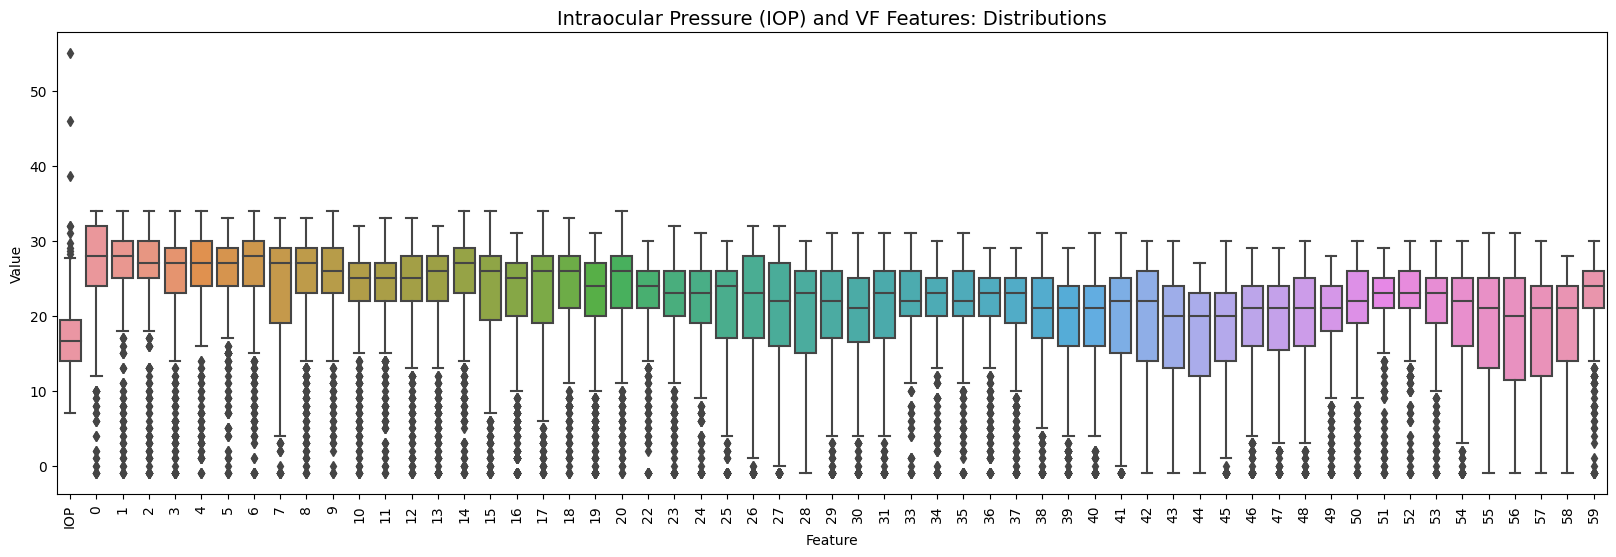

In [20]:
# Look at distribution of values across IOP (intraocular pressure) and all VF values
# NOTE: VF indices 21 and 32 correspond to blindspots; drop in all subjects
cols = ['IOP','0','1','2','3','4','5','6','7','8','9',
        '10','11','12','13','14','15','16','17','18','19','20', 
        '22','23','24','25','26','27','28','29','30','31','33',
        '34','35','36','37','38','39','40','41','42','43','44','45',
        '46','47','48','49','50','51','52','53','54','55','56','57',
        '58','59']

df_subset = GRAPE_followup_df_images[cols]

df_melted = df_subset.melt(var_name='Feature', value_name='Value')
plt.figure(figsize=(20,6))  # wide figure for 60 features
sns.boxplot(x='Feature', y='Value', data=df_melted)
plt.xticks(rotation=90)  # rotate x labels for readability
plt.title("Intraocular Pressure (IOP) and VF Features: Distributions", fontsize=14)
plt.show()


#### Initial Functions for Image Processing, VF Interpolation & Visualization

In [ ]:
from scipy.interpolate import Rbf

'''
GRAPE Follow Up VFs
'''

#grape_fu = pd.read_csv("data/GRAPE_FollowUps.csv")
#cropped_df = grape_fu.drop(columns = ['Interval Years', 'IOP', 'Corresponding CFP'])
cropped_df = GRAPE_followup_df_images.drop(columns = ['Interval Years', 'IOP','Corresponding CFP'])

cropped_np = np.array(cropped_df)

# coordinates by index (Octopus perimetry)
all_coords = np.array([
    (0,0), (1,-1), (-1,-1), (-1,1), (1,1), (2,-2), (-2,-2), (-2,2),
    (2,2), (4,-1), (4,-4), (1,-4), (-1,-4), (-4,-4), (-4,-1), (-4,1), (-4,4),
    (-1,4), (1,4), (4,4), (4,1), (6,0), (6,-6), (2,-6), (-2,-6), (-6,-6),
    (-6,-1), (-6,1), (-6,6), (-2,6), (2,6), (6,6), (8,-1), (8,-6), (8,-8), (6,-8), (2,-8), 
    (-2,-8), (-6,-8), (-8,-8), (-8,-6), (-8,-1), (-8,1), (-8,6), (-8,8), (-6,8), (-2,8), (2,8), (6,8),
    (8,8), (8,6), (8,1), (10,-3), (3,-10), (-3,-10), (-10, -2), (-10,2), (-3,10), (3,10), (10,3)
])

radius = 12

grid_x, grid_y = np.mgrid[-12:12:200j, -12:12:200j]
mask = (np.sqrt(grid_x**2 + grid_y**2) <= radius)
mask_float = mask.astype(np.float32)

"""
For each point in cropped_np, create a visual field map:

1. Take the point’s values (pt[3:]).
2. Interpolate over a grid using RBF with fixed VF coordinates.
3. Apply a circular mask of radius 12.
4. Replace values outside the mask with 0.
5. Save the result (values + mask) as a .npy file named "{pt[0]}_{pt[1]}.npy".

Final grid is (200, 200, 2)
    - [:,:,0]  interpolated visual field values
    - [:,:,1] mask indicating the visual field area (1.0 inside, 0.0 outside)
"""
for pt in cropped_np:
    pt_vf = np.array(pt[3:], dtype=int)

    rbf = Rbf(all_coords[:,0], all_coords[:,1], pt_vf, function='thin_plate')
    grid_z = rbf(grid_x, grid_y)
    masked_grid = np.where(mask, grid_z, np.nan)
    
    values = np.nan_to_num(masked_grid, nan=0.0)
    x = np.stack([values.T, mask_float], axis=-1)
    np.save(f"{pt[0]}_{pt[1]}_{pt[2]}.npy", x)

In [16]:
## Visual Field Interpolation (for row from df)
def interpolate_VF(row):
    
    VF_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
   '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
   '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
   '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
   '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57',
   '58', '59']
    
    VF_df = row[VF_cols]

    VF_np = np.array(VF_df)
    
    all_coords = np.array([
    (0,0), (1,-1), (-1,-1), (-1,1), (1,1), (2,-2), (-2,-2), (-2,2),
    (2,2), (4,-1), (4,-4), (1,-4), (-1,-4), (-4,-4), (-4,-1), (-4,1), (-4,4),
    (-1,4), (1,4), (4,4), (4,1), (6,0), (6,-6), (2,-6), (-2,-6), (-6,-6),
    (-6,-1), (-6,1), (-6,6), (-2,6), (2,6), (6,6), (8,-1), (8,-6), (8,-8), (6,-8), (2,-8), 
    (-2,-8), (-6,-8), (-8,-8), (-8,-6), (-8,-1), (-8,1), (-8,6), (-8,8), (-6,8), (-2,8), (2,8), (6,8),
    (8,8), (8,6), (8,1), (10,-3), (3,-10), (-3,-10), (-10, -2), (-10,2), (-3,10), (3,10), (10,3)])

    radius = 12

    grid_x, grid_y = np.mgrid[-12:12:200j, -12:12:200j]
    mask = (np.sqrt(grid_x**2 + grid_y**2) <= radius)
    mask_float = mask.astype(np.float32)
    
    """
    For each point in cropped_np, create a visual field map:
    
    1. Take the point’s values (pt[3:]).
    2. Interpolate over a grid using RBF with fixed VF coordinates.
    3. Apply a circular mask of radius 12.
    4. Replace values outside the mask with 0.
    5. Save the result (values + mask) as a .npy file named "{pt[0]}_{pt[1]}.npy".
    
    Final grid is (200, 200, 2)
        - [:,:,0]  interpolated visual field values
        - [:,:,1] mask indicating the visual field area (1.0 inside, 0.0 outside)
    """

    pt_vf = np.array(VF_np, dtype=float)

    rbf = Rbf(all_coords[:,0], all_coords[:,1], pt_vf, function='thin_plate')
    grid_z = rbf(grid_x, grid_y)
    masked_grid = np.where(mask, grid_z, np.nan)
    
    values = np.nan_to_num(masked_grid, nan=0.0)
    x = np.stack([values.T, mask_float], axis=-1)

    return x



In [17]:
# Plot interpolated VF (from array of VF values, which will be output from CNN)
def plot_VF(arr, mask_invalid=True, cmap='viridis'):
    """
    Plot visual field map from Octopus arr containing sensitivity and mask.
    """
    
    sens = arr[:,:,0]
    mask = arr[:,:,1]
    
    # Apply mask
    if mask_invalid:
        sens_masked = np.where((mask==0), np.nan, sens)
    else:
        sens_masked = sens

    plt.figure(figsize=(8,8))
    plt.imshow(sens_masked, cmap=cmap, origin='lower')
    plt.colorbar(label='Sensitivity (dB)')
    plt.title("Visual Field")
    plt.axis('off')
    plt.show()

In [ ]:
# Plot interpolated VF (from .npy file, as originally supplied by Lily Hirano)
def plot_vf_from_npy(file_path, mask_invalid=True, cmap='viridis'):
    """
    Plot visual field map from Octopus .npy file containing sensitivity and mask.
    
    Parameters:
        file_path: path to the .npy file
        mask_channel: mask channel in last dimension (1)
        sens_channel: sensitivities channel in last dimension (0)
        mask_invalid: if True, invalid points (mask==0 or sensitivity<0) set to NaN
        cmap: colormap for plotting
    """
    arr = np.load(file_path)
    
    sens = arr[:,:,0]
    mask = arr[:,:,1]
    
    # Apply mask
    if mask_invalid:
        sens_masked = np.where((mask==0), np.nan, sens)
    else:
        sens_masked = sens

    plt.figure(figsize=(8,8))
    plt.imshow(sens_masked, cmap=cmap, origin='lower')
    plt.colorbar(label='Sensitivity (dB)')
    plt.title("Visual Field")
    plt.axis('off')
    plt.show()

#### Exploration of left eye (OS), right eye (OD) image availability across patients

In [21]:
# assess unique subject count
GRAPE_followup_df_images["Subject Number"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144])

In [30]:
# Plot ROI and interpolated VFs to explore how they may relate to one another/feasibility of analysis
def plot_vf_cfp_grid(vf_left, vf_right, cfp_left, cfp_right, cmap='viridis', figsize=(3,3), subject=1, visit=1):
    """
    vf_left, vf_right: (H, W, 2) interpolated VF arrays from interpolate_VF()
    cfp_left, cfp_right: (H_img, W_img, 3) fundus images as numpy arrays
    """
    fig, axs = plt.subplots(2, 2, figsize=figsize)

    # First row: VF maps
    axs[0,0].imshow(vf_left[:,:,0], cmap=cmap)
    axs[0,0].set_title('VF (Left Eye)', fontsize=10)
    axs[0,0].axis('off')

    axs[0,1].imshow(vf_right[:,:,0], cmap=cmap)
    axs[0,1].set_title('VF (Right Eye)', fontsize=10)
    axs[0,1].axis('off')

    # Second row: CFP images
    #cfp_left = np.array(Image.open(cfp_left)).astype(np.float32)
    axs[1,0].imshow(cfp_left)
    axs[1,0].set_title('CFP (Left Eye)', fontsize=10)
    axs[1,0].axis('off')

    #cfp_right = np.array(Image.open(cfp_right)).astype(np.float32)
    axs[1,1].imshow(cfp_right)
    axs[1,1].set_title('CFP (Right Eye)', fontsize=10)
    axs[1,1].axis('off')

    fig.suptitle(f"Subject {subject}, Visit {visit}", fontsize=12)

    plt.tight_layout()
    plt.show()


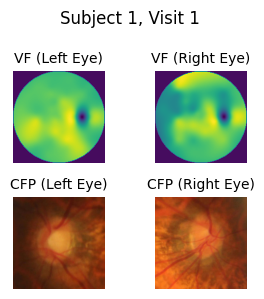

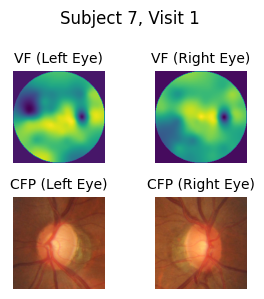

In [31]:
# Look at example eye sets
# for subject in GRAPE_followup_df_images["Subject Number"].unique():
for subject in [1,7]:  # look at just two subjects for now
    subject_df = GRAPE_followup_df_images[GRAPE_followup_df_images["Subject Number"] == subject]
    visits = sorted(list(subject_df["Visit Number"].unique()))
    eyes = list(subject_df["Laterality"].unique())
    visit = 1
    left_eye = subject_df[(subject_df["Laterality"] == "OS") & (subject_df["Visit Number"] == visit)]
    right_eye = subject_df[(subject_df["Laterality"] == "OD") & (subject_df["Visit Number"] == visit)]

    vf_left = interpolate_VF(left_eye.iloc[0])
    vf_right = interpolate_VF(right_eye.iloc[0])

    cfp_left = subject_df[(subject_df["Laterality"] == "OS") & (subject_df["Visit Number"] == visit)]["Corresponding CFP"].iloc[0]
    cfp_right = subject_df[(subject_df["Laterality"] == "OD") & (subject_df["Visit Number"] == visit)]["Corresponding CFP"].iloc[0]
    
    size = (200, 200)
    cfp_left_img = np.array(Image.open(cfp_left).resize(size)).astype(np.uint8)
    cfp_right_img = np.array(Image.open(cfp_right).resize(size)).astype(np.uint8)
    
    plot_vf_cfp_grid(vf_left, vf_right, cfp_left_img, cfp_right_img, subject=subject, visit=visit)


#### EDA: Image count assessments

In [34]:
# First visit CFPs
from collections import Counter
Counter(GRAPE_df.groupby('Subject Number')['Corresponding CFP'].count())

Counter({2: 119, 1: 25})

In [35]:
# 119 subjects have both eye data; 25 have 1 eye data -> 144 total subjects
Counter(GRAPE_df['Total Visits'])

Counter({3: 100, 4: 75, 7: 13, 6: 32, 5: 38, 8: 3, 9: 2})

There are 263 ROI images


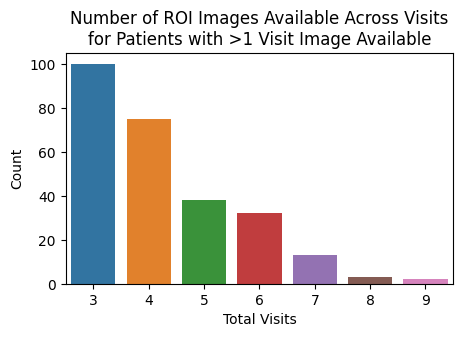

In [48]:
# Evaluate number of images available for each visit, across entire visit distribution
counts = Counter(GRAPE_df['Total Visits'])

df_counts = pd.DataFrame({
    'Total Visits': list(counts.keys()),
    'Count': list(counts.values())})

count = df_counts["Count"].sum()
print(f"There are {count } ROI images")
plt.figure(figsize=(5,3))
sns.barplot(data=df_counts, x='Total Visits', y='Count')
plt.title("Number of ROI Images Available Across Visits\nfor Patients with >1 Visit Image Available")
plt.show()

There are 144 Subjects


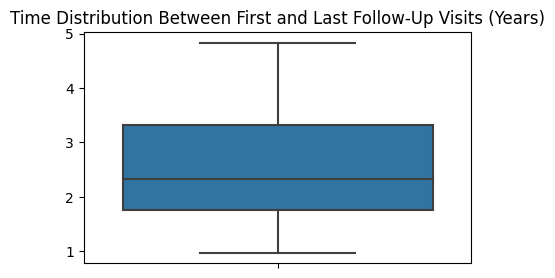

In [37]:
# Evaluate distribution of times between first and last follow-up visits
times = []
subject_counter = 0
number_visits = []
for subject in GRAPE_followup_df["Subject Number"].unique():
    subject_df = GRAPE_followup_df[GRAPE_followup_df["Subject Number"] == subject]
    visits = sorted(list(subject_df["Visit Number"].unique()))
    time = subject_df[subject_df["Visit Number"] == visits[-1]]["Interval Years"].iloc[0]
    times.append(time)
    subject_counter += 1
    number_visits.append(len(visits))
print(f"There are {subject_counter} Subjects")
plt.figure(figsize=(5,3))
plt.title("Time Distribution Between First and Last Follow-Up Visits (Years)")
sns.boxplot(y=times);


There are 106 Subjects


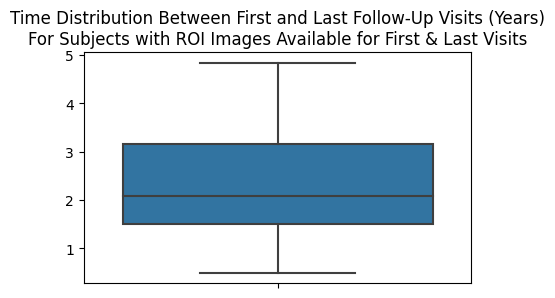

In [38]:
# Now check for those with images that also correspond across the time frame

times_images = []
subject_counter = 0
number_visits = []

for subject in GRAPE_followup_df_images["Subject Number"].unique():
    subject_df = GRAPE_followup_df_images[GRAPE_followup_df_images["Subject Number"] == subject]
    visits = sorted(list(subject_df["Visit Number"].unique()))
    if len(visits) > 1:
        time = subject_df[subject_df["Visit Number"] == visits[-1]]["Interval Years"].iloc[0]
        times_images.append(time)
        subject_counter += 1
        number_visits.append(len(visits))
        
print(f"There are {subject_counter} Subjects")
plt.figure(figsize=(5,3))
plt.title("Time Distribution Between First and Last Follow-Up Visits (Years)\nFor Subjects with ROI Images Available for First & Last Visits")
sns.boxplot(y=times_images);


There are 106 ROI images


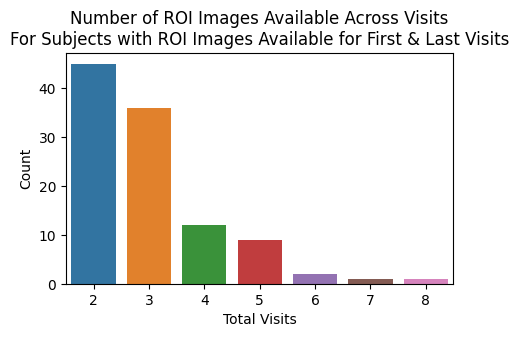

In [50]:
# Evaluate number of images available for each visit, across entire visit distribution
counts = Counter(number_visits)

df_counts = pd.DataFrame({
    'Total Visits': list(counts.keys()),
    'Count': list(counts.values())})

count = df_counts["Count"].sum()
print(f"There are {count } ROI images")
plt.figure(figsize=(5,3))
sns.barplot(data=df_counts, x='Total Visits', y='Count')
plt.title("Number of ROI Images Available Across Visits\nFor Subjects with ROI Images Available for First & Last Visits")
plt.show()

# Convolutional Neural Network

In Exploratory Data Analysis, we evaluated the CFP ROI (color fundus photograph region of interest) image count available for subjects that have ROI images available for 1st and last follow-up visits.  There are 144 total subjects in the GRAPE dataset, all with first-visit ROI images; across these 144 total subjects, there are 631 total images.  106 of the 144 subjects have additional images available beyond the first visit (i.e., follow-up visit data available); across these 106 subjects, there are cumulatively 263 images sprinkled across follow-up visits.  Only 106 of the subjects have paired images available for both the first and the last logged visit (i.e., only 106 images with maximal study time span available).  

**Given these observations, we chose to use ALL 631 ROI images in an initial CNN evaluation, and did not take into account visit identity or any time course component to the CNN predictive tasks.  The goal of this CNN is to extract feature information from the cropped ROI (focus on the optic nerve head where glaucomic damage is concentrated) and to use the extracted features to predict 58 visual field sensitivity data points as multi-output regression targets.**


In [56]:
# import modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import numpy as np

### Finalized CNN

In [57]:
# 12-09-2025
# Overall CNN with ROI as input, optimal parameters from sweep, minmax scaler with tanh as final activation function

# Define CNN
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers: extract local spatial patterns
        # convolution layer 1: lines, edges, simpler textures
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)  # in_channels, out_channels, kernel size (3x3)
        self.pool1 = nn.MaxPool2d(2,2)  # max pooling layer; reduce spatial size of feature maps by 1/2: (kernel_size, stride)

        # convolution layer 2: more complex patterns
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)  # increase out_channels to 128 to accommodate more complex features
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=2)  # capture finer-grained detail in feature maps
        self.pool3 = nn.AdaptiveAvgPool2d((4,4))  # average pooling layer (take average instead of max value); apparently better for regression tasks

        self.flatten = nn.Flatten()  # convert 2D tensor to 1D tensor

        # Fully connected (dense) layers: learn relationships among features
        # Dense layer 1: 
        self.fc1 = nn.Linear(256*4*4, 512)  # out_features, in_features: 1024 neurons are going to learn weighted combination of 256x4x4 features
        self.drop1 = nn.Dropout(p=0.1)  # set random 10% of neurons to 0 in each training iterations

        self.fc2 = nn.Linear(512, 256)
        self.drop2 = nn.Dropout(p=0.1)

        # Output layer: map learned features to 58 predictions (leave out columns 21,32 blind spots)
        self.out = nn.Linear(256, 58)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        x = torch.tanh(self.out(x))
        
        return x

# Image transformation function
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])])

def tensor_transform(image_path):
    img = Image.open(image_path).convert('RGB')
    return transform(img)

# prepare to scale data
from sklearn.preprocessing import MinMaxScaler

scaler_y = MinMaxScaler(feature_range=(0, 1))

# no masking of -1 as NaN; convert -1 to 0 as masking instead.  Drop blind spot columns (index 21 and 32)
cols = ['0','1','2','3','4','5','6','7','8','9',
        '10','11','12','13','14','15','16','17','18','19','20',
        '22','23','24','25','26','27','28','29','30','31','33',
        '34','35','36','37','38','39','40','41','42','43','44','45',
        '46','47','48','49','50','51','52','53','54','55','56','57',
        '58','59']

GRAPE_followup_df_images_masked = GRAPE_followup_df_images.replace(-1, 0)
targets_masked = GRAPE_followup_df_images_masked[cols].copy()

# scale data
targets_scaled = scaler_y.fit_transform(targets_masked)

# prepare dataset: list of (img_tensor, feature_tensor) tuples
dataset = []
for index, row in GRAPE_followup_df_images_masked.iterrows():
    image_path = row["Corresponding CFP"]

    img = Image.open(image_path).convert("RGB")

    if row["Laterality"] == "OS":  # flip left eye images across the vertial for orientation consistency with right eye images
        img = ImageOps.mirror(img)

    img_tensor = transform(img)
    target_tensor = torch.from_numpy(targets_scaled[index]).float()
    dataset.append((img_tensor, target_tensor))

images = torch.stack([item[0] for item in dataset])
targets = torch.stack([item[1] for item in dataset])

full_dataset = TensorDataset(images, targets)

# split dataset as 80% training/20% validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
trainset, valset = random_split(full_dataset, [train_size, val_size]) # [train_size, val_size] = how many samples go into each split

batch_size = 8
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)  # shuffle=True -> random image order during each training epoch
valloader = DataLoader(valset, batch_size=batch_size)

# instantiate CNN as net
net = NeuralNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

# define training/validation functions, returning avg loss
def train_one_epoch():
    net.train()
    running_loss = 0.0  # prepare to accumulate loss

    for inputs, labels in trainloader:
        labels = labels.float()
        optimizer.zero_grad()  # clear out gradients stored from previous batch iterations
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)  # weight by batch size (inputs.size(0))

    avg_loss = running_loss / len(trainloader.dataset)
    print(f"Train loss: {avg_loss}")
    return avg_loss

def validate_one_epoch():
    net.eval()
    running_loss = 0.0  # prepare to accumulate loss

    with torch.no_grad():  # validation doesn't need weight updates; inactivate gradient tracking and updating
        for inputs, labels in valloader:
            labels = labels.float()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

    avg_loss = running_loss / len(valloader.dataset)
    print(f"Validation loss: {avg_loss:.4f}")
    return avg_loss

# training run
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_one_epoch()
    val_loss = validate_one_epoch()
    # track training & validation losses
    print(f"Epoch {epoch+1}/{num_epochs} — train: {train_loss:.4f}, val: {val_loss:.4f}")


Train loss: 0.13153338863972633
Validation loss: 0.0635
Epoch 1/20 — train: 0.1315, val: 0.0635
Train loss: 0.06629067547028027
Validation loss: 0.0627
Epoch 2/20 — train: 0.0663, val: 0.0627
Train loss: 0.0637760493490431
Validation loss: 0.0546
Epoch 3/20 — train: 0.0638, val: 0.0546
Train loss: 0.05971195903562364
Validation loss: 0.0516
Epoch 4/20 — train: 0.0597, val: 0.0516
Train loss: 0.04864993954579982
Validation loss: 0.0478
Epoch 5/20 — train: 0.0486, val: 0.0478
Train loss: 0.04877799338409825
Validation loss: 0.0459
Epoch 6/20 — train: 0.0488, val: 0.0459
Train loss: 0.044967362598057774
Validation loss: 0.0570
Epoch 7/20 — train: 0.0450, val: 0.0570
Train loss: 0.045635318028784934
Validation loss: 0.0437
Epoch 8/20 — train: 0.0456, val: 0.0437
Train loss: 0.04444947194248911
Validation loss: 0.0481
Epoch 9/20 — train: 0.0444, val: 0.0481
Train loss: 0.04433948046986073
Validation loss: 0.0448
Epoch 10/20 — train: 0.0443, val: 0.0448
Train loss: 0.043498780430545884
Valid

In [58]:
# evaluate after training
net.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in valloader:
        outputs = net(inputs)
        all_preds.append(outputs.cpu())
        all_true.append(labels.cpu())

# stack all batches
pred_scaled = torch.cat(all_preds).numpy()
true_scaled = torch.cat(all_true).numpy()

# inverse transform back to dB
pred_db = scaler_y.inverse_transform(pred_scaled)
true_db = scaler_y.inverse_transform(true_scaled)

# compute RMSE in original dB units
rmse_db = np.sqrt(np.mean((pred_db - true_db)**2))

print(f"Validation RMSE (dB): {rmse_db:.2f}")

Validation RMSE (dB): 6.21


### Parameter Sweep Effort

Following preliminary CNN efforts (archived below), it became evident that a hyperparameter sweep might help us identify parameter combinations to lower overall loss (improve predictive performance). **We tested 36 parameter combinations focusing on learning rate, batch size, dropout, and activation function after dense layers (paired with scaling function)**.

In [ ]:
# Hyperparameter sweep
learning_rate = [1e-4, 3e-4, 5e-4]
batch_size = [8, 16]
dropout = [0.1, 0.3, 0.5]
activation_function = [('standard', 'relu'), ('minmax_m11', 'tanh')]

In [ ]:
# Define CNN Class as an instance of torch.nn Module
class NeuralNet(nn.Module):  # instantiate neural net from torch.nn Module
    def __init__(self, dropout=0.3, activation='relu'):  # enable parameters to be passed to class instance
        super().__init__()

        self.activation_name = activation  # for output layer

        # Convolutional layers: extract local spatial patterns
        # convolution layer 1: lines, edges, simpler textures
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)  # in_channels, out_channels, kernel size (3x3)
        self.pool1 = nn.MaxPool2d(2,2)  # max pooling layer; reduce spatial size of feature maps by 1/2: (kernel_size, stride)

        # convolution layer 2: more complex patterns
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)  # increase out_channels to 128 to accommodate more complex features
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=2)  # capture finer-grained detail in feature maps
        self.pool3 = nn.AdaptiveAvgPool2d((4,4))  # average pooling layer (take average instead of max value); apparently better for regression tasks

        self.flatten = nn.Flatten()  # convert 2D tensor to 1D tensor

        # Fully connected (dense) layers: learn relationships among features
        # Dense layer 1: 
        self.fc1 = nn.Linear(256*4*4, 512)  # out_features, in_features: 1024 neurons are going to learn weighted combination of 512x4x4 features
        self.drop1 = nn.Dropout(p=dropout)  # set random % of neurons to 0 in each training iteration

        self.fc2 = nn.Linear(512, 256)
        self.drop2 = nn.Dropout(p=dropout)

        # Output layer: map learned features to 58 predictions (leave out columns 21,32 blind spots)
        self.out = nn.Linear(256, 58)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        if self.activation_name == 'tanh':
            x = torch.tanh(self.out(x))
        else:
            x = self.out(x)
        
        return x

In [ ]:
### RUN THIS ONE for parameter sweep

# Image transformation function
transform2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

def tensor_transform2(image_path):
    img = Image.open(image_path).convert('RGB')
    return transform2(img)

# Preload all images once (outside sweep loop)
preloaded_images = []
for index, row in GRAPE_followup_df_images_masked.iterrows():
    image_path = row["Corresponding CFP"]
    img = Image.open(image_path).convert("RGB")
    if row["Laterality"] == "OS":
        img = ImageOps.mirror(img)
    img_tensor = transform2(img)
    preloaded_images.append(img_tensor)
preloaded_images = torch.stack(preloaded_images)

# training run (loop for parameter sweep)
num_epochs = 20
sweep_dict = {}
learning_rate_list = [1e-4, 3e-4, 5e-4]
batch_size_list = [8, 16]
dropout_list = [0.1, 0.3, 0.5]
activation_function_list = [('standard', 'relu'), ('minmax_m01', 'tanh')]

for lr in learning_rate_list:
    for bs in batch_size_list:
        for do in dropout_list:
            for af in activation_function_list:
                activation_name = af[1]
                scaling = af[0]

                # Instantiate model and optimizer
                net = NeuralNet(dropout=do, activation=activation_name)
                optimizer = optim.Adam(net.parameters(), lr=lr)
                criterion = nn.MSELoss()
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

                # Choose scaler
                if scaling == 'standard':
                    scaler_y = StandardScaler()
                elif scaling == 'minmax_m01':
                    scaler_y = MinMaxScaler(feature_range=(0, 1))

                # Scale targets
                targets_scaled = scaler_y.fit_transform(targets_masked)
                targets_tensor = torch.from_numpy(targets_scaled).float()

                # Create full dataset
                full_dataset = TensorDataset(preloaded_images, targets_tensor)

                train_size = int(0.8 * len(full_dataset))
                val_size = len(full_dataset) - train_size
                trainset, valset = random_split(full_dataset, [train_size, val_size])

                # Create DataLoaders
                trainloader = DataLoader(trainset, batch_size=bs, shuffle=True)
                valloader = DataLoader(valset, batch_size=bs)

                # Track losses
                train_loss_log = []
                val_loss_log = []

                combination = f"{lr}_{bs}_{do}_{activation_name}"
                print(f"\nlr = {lr}, bs = {bs}, do = {do}, af = {activation_name}")

                for epoch in range(num_epochs):
                    train_loss = train_one_epoch()
                    val_loss = validate_one_epoch()
                    scheduler.step(val_loss)
                    train_loss_log.append(train_loss)
                    val_loss_log.append(val_loss)
                    print(f"Epoch {epoch+1}/{num_epochs} — train: {train_loss:.4f}, val: {val_loss:.4f}")

                sweep_dict[combination] = (train_loss_log, val_loss_log)


In [ ]:
# pickle sweep_dict for reload and reuse
import pickle as pkl
with open("sweep_dict.pkl", "wb") as f:
    pkl.dump(sweep_dict, f)

In [87]:
# reload sweep_dict if needed
import pickle as pkl
with open("sweep_dict.pkl", "rb") as f:
    sweep_dict = pkl.load(f)

In [89]:
# separate relu and tanh as separate dicts, from sweep_dict
import re
relu_dict = {k: v for k, v in sweep_dict.items() if re.search("relu", k)}

tanh_dict = {k: v for k, v in sweep_dict.items() if re.search("tanh", k)}

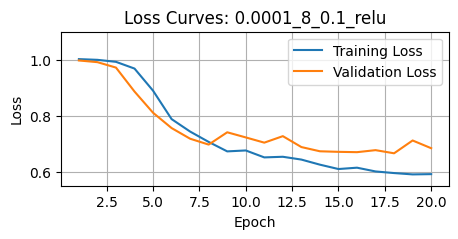

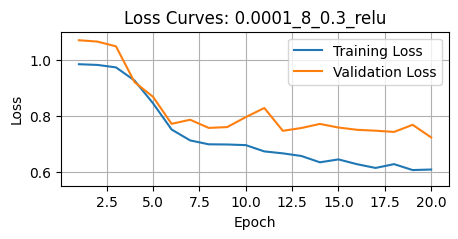

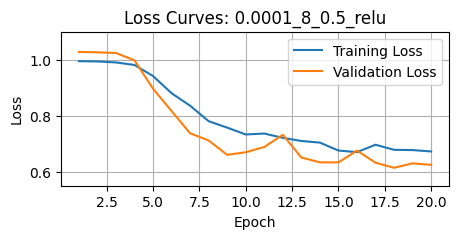

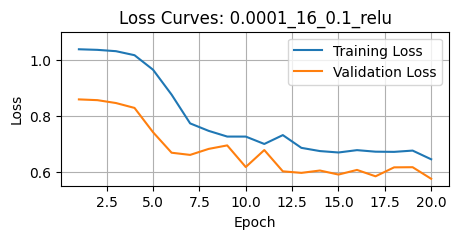

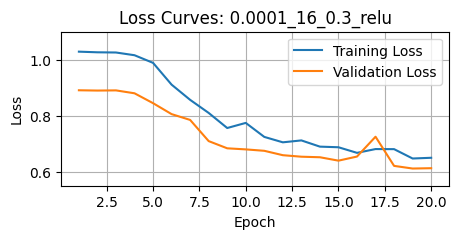

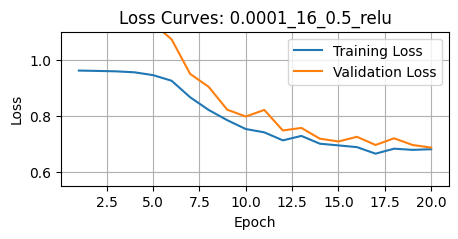

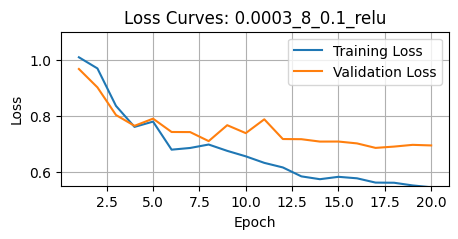

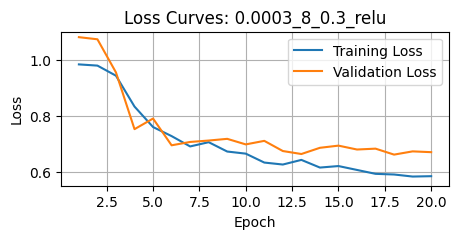

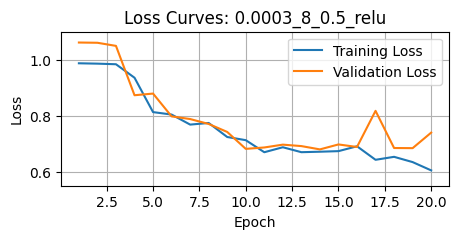

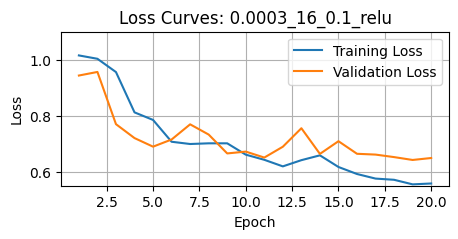

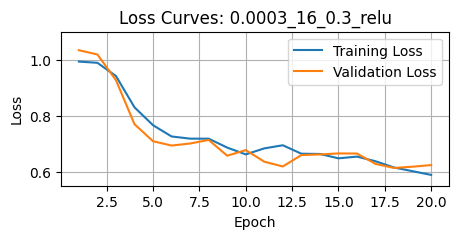

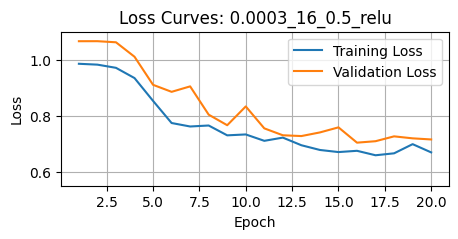

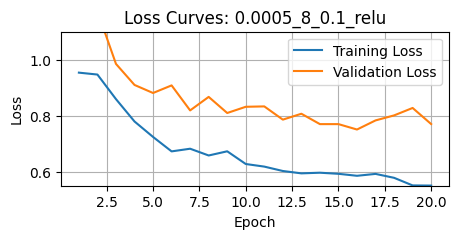

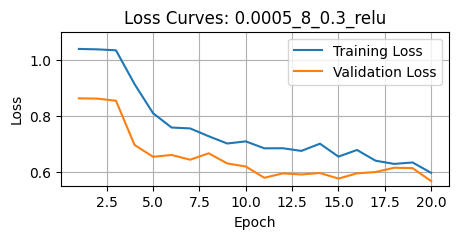

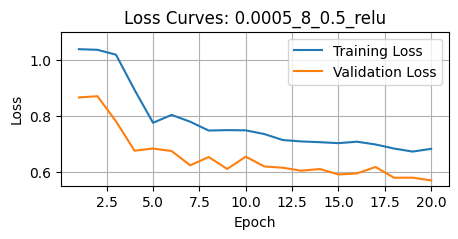

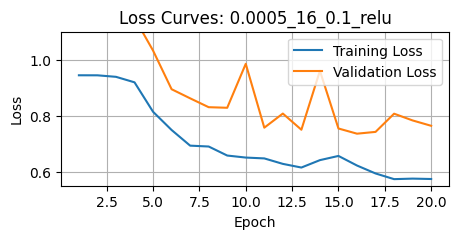

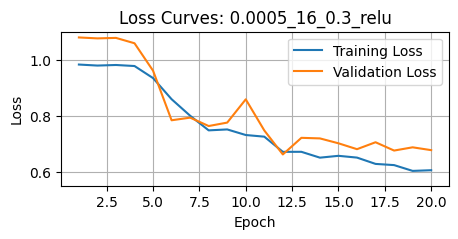

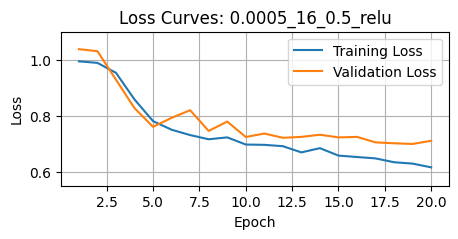

In [95]:
# Evaluate loss curves: RELU

for combination, (train_losses, val_losses) in relu_dict.items():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(5,2))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(0.55, 1.1)
    plt.title(f"Loss Curves: {combination}")
    plt.legend()
    plt.grid(True)

    plt.show()

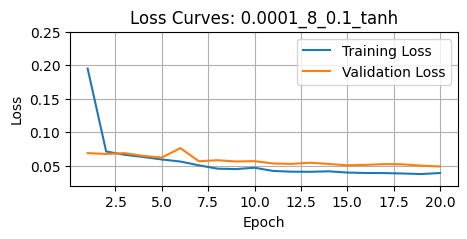

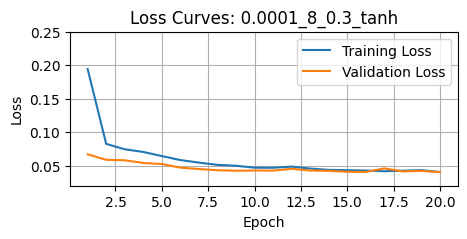

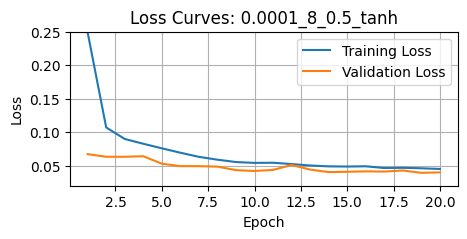

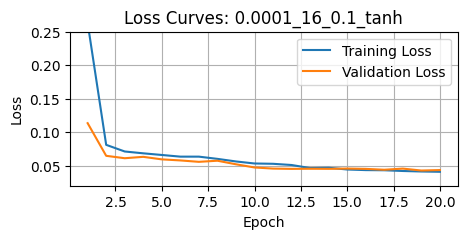

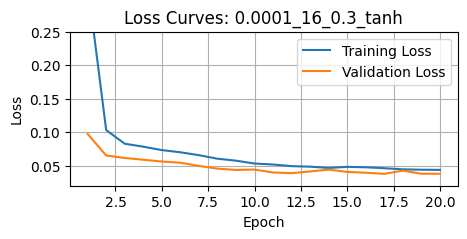

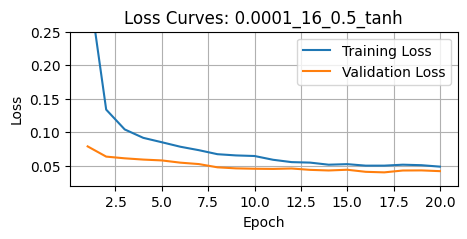

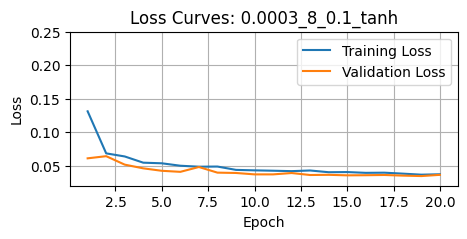

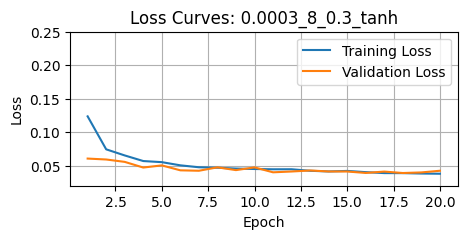

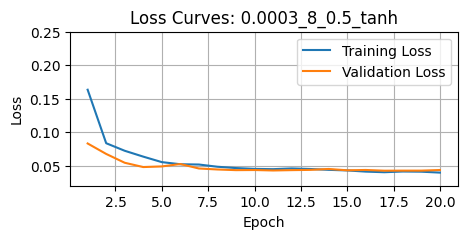

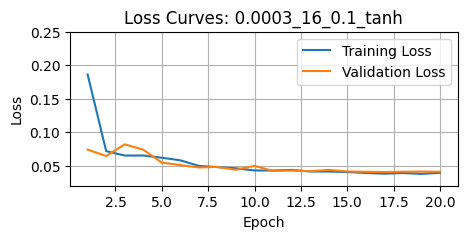

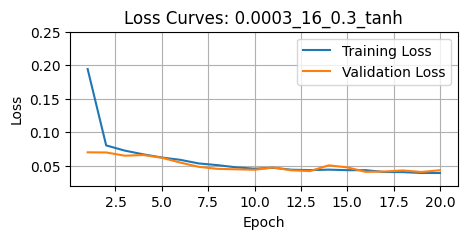

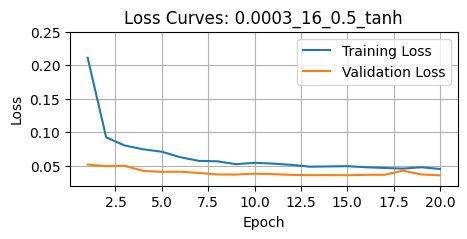

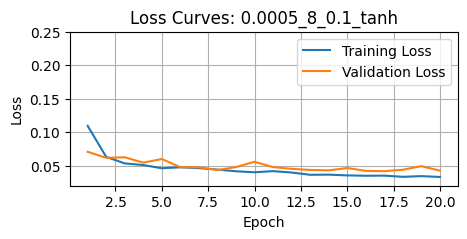

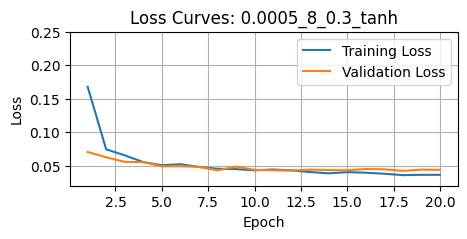

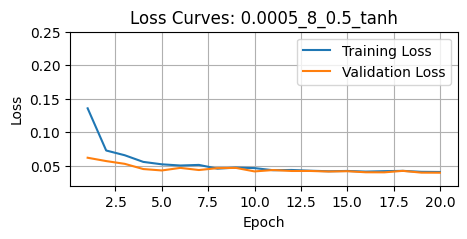

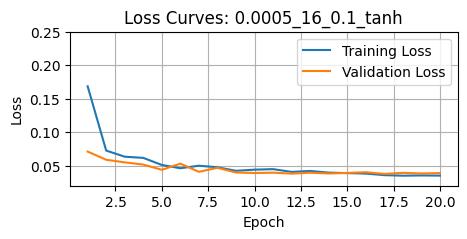

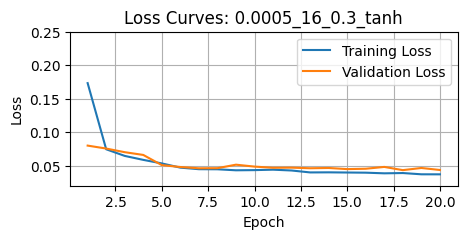

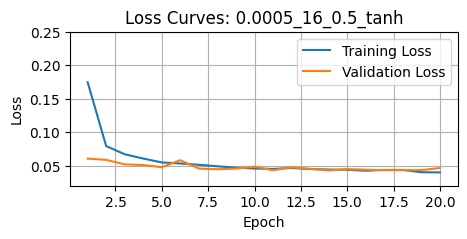

In [109]:
# Evaluate loss curves: TANH

for combination, (train_losses, val_losses) in tanh_dict.items():
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(5,2))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(0.02, 0.25)
    plt.title(f"Loss Curves: {combination}")
    plt.legend()
    plt.grid(True)

    plt.show()

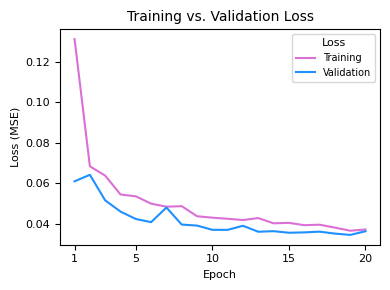

In [111]:
# Parameter Sweep evaluation: focus special plot for optimal parameters (from finalized CNN at beginning of notebook)

train_losses, val_losses = tanh_dict["0.0003_8_0.1_tanh"]
epochs = list(range(1, len(train_losses)+1))
df = pd.DataFrame({"epoch": epochs, "Training": train_losses, "Validation": val_losses})

df_long = df.melt(id_vars="epoch", value_vars=["Training", "Validation"],
                  var_name="Loss", value_name="loss")

plt.figure(figsize=(4,3))
sns.lineplot(data=df_long, x="epoch", y="loss", hue="Loss", palette=["orchid","dodgerblue"])

plt.title(f"Training vs. Validation Loss",
         fontsize=10)
plt.xlabel("Epoch", fontsize=8)
plt.ylabel("Loss (MSE)", fontsize=8)
plt.xticks(ticks=[1, 5, 10, 15, 20], fontsize=8)
plt.yticks(fontsize=8)
plt.legend(title="Loss", title_fontsize=8, fontsize=7)
plt.tight_layout()
#plt.savefig("Loss_example2", dpi=300, bbox_inches="tight")
plt.show()

### CNN Model Evaluation

Model Evaluation was performed for finalized CNN as follows.

In [112]:
# visualization of aggregate true-predicted (MSE) across VF
(true_db - pred_db)**2

array([[9.7609711e+01, 7.1260880e+01, 1.2929420e+02, ..., 5.6939461e+01,
        1.2592755e+02, 3.1326248e+02],
       [3.1170950e+00, 1.0528737e+00, 1.2098120e+00, ..., 2.2618525e+01,
        2.0269867e+01, 1.5914818e-02],
       [8.5460052e-02, 2.5155881e-01, 5.4455799e-01, ..., 9.6301991e-04,
        2.3553503e+01, 8.7544031e+00],
       ...,
       [1.0294423e+01, 1.0336091e+01, 4.4061974e-02, ..., 4.3085934e+01,
        4.6875298e+01, 2.2981070e+01],
       [1.4918488e+01, 3.6875327e+02, 4.7694130e+01, ..., 4.5272082e-02,
        4.1511127e+01, 2.6397049e-01],
       [6.1307969e+00, 9.6271271e+01, 8.4024673e+01, ..., 9.1140327e+01,
        1.1733560e+01, 2.7251101e+01]], dtype=float32)

In [60]:
# squared error per VF point (shape: [num_samples, 58])
squared_errors = (true_db - pred_db) ** 2

# mean squared error across all samples for each VF point
mse_per_point = np.mean(squared_errors, axis=0)

In [61]:
mse_per_point

array([30.835155, 38.778316, 32.235233, 44.92347 , 39.960804, 33.256683,
       36.563263, 40.853382, 34.919277, 28.194973, 30.814829, 26.778742,
       31.41006 , 44.05156 , 39.345146, 35.889736, 59.920376, 40.974403,
       30.394405, 39.377472, 29.84134 , 25.20058 , 29.890333, 33.57565 ,
       43.210457, 49.346317, 62.71983 , 57.360237, 55.11121 , 41.968227,
       32.630444, 26.736038, 27.535418, 23.832272, 29.745565, 30.021599,
       34.711956, 33.72063 , 39.30284 , 50.322533, 54.17517 , 52.705196,
       51.117672, 53.107147, 49.54288 , 40.41969 , 35.406208, 31.793385,
       26.203556, 28.007687, 33.107304, 26.324924, 35.42892 , 46.615673,
       53.83865 , 54.742302, 38.247143, 32.3886  ], dtype=float32)

In [62]:
rmse_per_point = np.sqrt(mse_per_point)

In [63]:
len(rmse_per_point)

58

In [64]:
rmse_per_point

array([5.5529413, 6.227224 , 5.677608 , 6.7024975, 6.321456 , 5.766861 ,
       6.0467563, 6.391665 , 5.9092536, 5.309894 , 5.5511107, 5.174818 ,
       5.604468 , 6.637135 , 6.272571 , 5.990804 , 7.740825 , 6.401125 ,
       5.513112 , 6.275147 , 5.462723 , 5.020018 , 5.467205 , 5.79445  ,
       6.5734663, 7.0246935, 7.919585 , 7.573654 , 7.4236927, 6.478289 ,
       5.7123065, 5.1706905, 5.2474203, 4.8818307, 5.4539495, 5.479197 ,
       5.8916855, 5.8069468, 6.269198 , 7.0938377, 7.3603783, 7.2598343,
       7.1496625, 7.287465 , 7.0386705, 6.357648 , 5.9503117, 5.638562 ,
       5.118941 , 5.2922287, 5.753895 , 5.130782 , 5.95222  , 6.827567 ,
       7.3374825, 7.398804 , 6.1844273, 5.691098 ], dtype=float32)

In [ ]:
# Revisit original interpolate_VF_array function (from Lily Hirano)

def interpolate_VF_array(arr):
    
    VF_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
   '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
   '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
   '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
   '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57',
   '58', '59']
    
    all_coords = np.array([
    (0,0), (1,-1), (-1,-1), (-1,1), (1,1), (2,-2), (-2,-2), (-2,2),
    (2,2), (4,-1), (4,-4), (1,-4), (-1,-4), (-4,-4), (-4,-1), (-4,1), (-4,4),
    (-1,4), (1,4), (4,4), (4,1), (6,0), (6,-6), (2,-6), (-2,-6), (-6,-6),
    (-6,-1), (-6,1), (-6,6), (-2,6), (2,6), (6,6), (8,-1), (8,-6), (8,-8), (6,-8), (2,-8), 
    (-2,-8), (-6,-8), (-8,-8), (-8,-6), (-8,-1), (-8,1), (-8,6), (-8,8), (-6,8), (-2,8), (2,8), (6,8),
    (8,8), (8,6), (8,1), (10,-3), (3,-10), (-3,-10), (-10, -2), (-10,2), (-3,10), (3,10), (10,3)])

    radius = 12

    grid_x, grid_y = np.mgrid[-12:12:200j, -12:12:200j]
    mask = (np.sqrt(grid_x**2 + grid_y**2) <= radius)
    mask_float = mask.astype(np.float32)
    
    """
    For each point in cropped_np, create a visual field map:
    
    1. Take the point’s values (pt[3:]).
    2. Interpolate over a grid using RBF with fixed VF coordinates.
    3. Apply a circular mask of radius 12.
    4. Replace values outside the mask with 0.
    5. Save the result (values + mask) as a .npy file named "{pt[0]}_{pt[1]}.npy".
    
    Final grid is (200, 200, 2)
        - [:,:,0]  interpolated visual field values
        - [:,:,1] mask indicating the visual field area (1.0 inside, 0.0 outside)
    """

    pt_vf = np.array(arr, dtype=float)

    rbf = Rbf(all_coords[:,0], all_coords[:,1], pt_vf, function='thin_plate')
    grid_z = rbf(grid_x, grid_y)
    masked_grid = np.where(mask, grid_z, np.nan)
    
    values = np.nan_to_num(masked_grid, nan=0.0)
    x = np.stack([values.T, mask_float], axis=-1)

    return x

In [65]:
# modify interpolate_VF_array to accommodate having dropped two blind spot indices

def interpolate_VF_array_no_blindspot(arr):

    blind_indices = [21, 32]   # blind spot coordinate indices

    # full 60-point coordinate layout
    all_coords = np.array([
    (0,0), (1,-1), (-1,-1), (-1,1), (1,1), (2,-2), (-2,-2), (-2,2),
    (2,2), (4,-1), (4,-4), (1,-4), (-1,-4), (-4,-4), (-4,-1), (-4,1), (-4,4),
    (-1,4), (1,4), (4,4), (4,1), (6,0), (6,-6), (2,-6), (-2,-6), (-6,-6),
    (-6,-1), (-6,1), (-6,6), (-2,6), (2,6), (6,6), (8,-1), (8,-6), (8,-8), (6,-8), (2,-8), 
    (-2,-8), (-6,-8), (-8,-8), (-8,-6), (-8,-1), (-8,1), (-8,6), (-8,8), (-6,8), (-2,8), (2,8), (6,8),
    (8,8), (8,6), (8,1), (10,-3), (3,-10), (-3,-10), (-10, -2), (-10,2), (-3,10), (3,10), (10,3)])

    # remove blind spot coordinates
    coords_58 = np.delete(all_coords, blind_indices, axis=0)

    # 58 RMSE values
    pt_vf = np.array(arr, dtype=float)

    # interpolation grid and mask
    radius = 12
    grid_x, grid_y = np.mgrid[-12:12:200j, -12:12:200j]
    mask = (np.sqrt(grid_x**2 + grid_y**2) <= radius)
    mask_float = mask.astype(np.float32)

    # interpolate
    rbf = Rbf(coords_58[:,0], coords_58[:,1], pt_vf, function='thin_plate')
    grid_z = rbf(grid_x, grid_y)
    masked_grid = np.where(mask, grid_z, np.nan)

    values = np.nan_to_num(masked_grid, nan=0.0)
    x = np.stack([values.T, mask_float], axis=-1)

    return x

In [66]:
# removal of blind spot coordinates (test, used in function above)

blind_indices = [21, 32] 
all_coords = np.array([
(0,0), (1,-1), (-1,-1), (-1,1), (1,1), (2,-2), (-2,-2), (-2,2),
(2,2), (4,-1), (4,-4), (1,-4), (-1,-4), (-4,-4), (-4,-1), (-4,1), (-4,4),
(-1,4), (1,4), (4,4), (4,1), (6,0), (6,-6), (2,-6), (-2,-6), (-6,-6),
(-6,-1), (-6,1), (-6,6), (-2,6), (2,6), (6,6), (8,-1), (8,-6), (8,-8), (6,-8), (2,-8), 
(-2,-8), (-6,-8), (-8,-8), (-8,-6), (-8,-1), (-8,1), (-8,6), (-8,8), (-6,8), (-2,8), (2,8), (6,8),
(8,8), (8,6), (8,1), (10,-3), (3,-10), (-3,-10), (-10, -2), (-10,2), (-3,10), (3,10), (10,3)])

# remove blind spot coordinates
coords_58 = np.delete(all_coords, blind_indices, axis=0)
len(coords_58)

58

In [67]:
len(rmse_per_point)

58

In [80]:
# Original function to plot VF sensitivity, modified to exclude blind spots
def plot_VF_original(arr, mask_invalid=True, cmap='viridis'):
    sens = arr[:,:,0]
    mask = arr[:,:,1]
    
    # Apply mask
    if mask_invalid:
        sens_masked = np.where((mask==0), np.nan, sens)
    else:
        sens_masked = sens

    plt.figure(figsize=(8,8))
    plt.imshow(sens_masked, cmap=cmap, origin='lower')
    plt.colorbar(label='VF Sensitivity (dB)', shrink=0.7)
    plt.title("VF Sensitivity (dB)", fontsize=15)
    plt.axis('off')
    plt.show()


In [69]:
# Function to plot predicted-true across VF (predicted-true in plot title)
def plot_VF_diff(arr, mask_invalid=True, cmap='viridis'):
    sens = arr[:,:,0]
    mask = arr[:,:,1]
    
    # Apply mask
    if mask_invalid:
        sens_masked = np.where((mask==0), np.nan, sens)
    else:
        sens_masked = sens

    plt.figure(figsize=(8,8))
    plt.imshow(sens_masked, cmap=cmap, origin='lower')
    plt.colorbar(label='Predicted-True Sensitivity (dB)', shrink=0.7)
    plt.title("Predicted-True Sensitivity Across VF", fontsize=15)
    plt.axis('off')
    plt.show()

In [70]:
# Function to plot RMSE across VF (RMSE in plot title)
def plot_VF_RMSE(arr, mask_invalid=True, cmap='viridis'):
    sens = arr[:,:,0]
    mask = arr[:,:,1]
    
    # Apply mask
    if mask_invalid:
        sens_masked = np.where((mask==0), np.nan, sens)
    else:
        sens_masked = sens

    plt.figure(figsize=(8,8))

    im = plt.imshow(
        sens_masked,
        cmap=cmap,
        origin='lower',
        vmin=0,        
        vmax=30        
    )
    
    plt.imshow(sens_masked, cmap=cmap, origin='lower')
    plt.colorbar(im, label='RMSE Sensitivity (dB)', shrink=0.7)
    plt.title("RMSE Across VF", fontsize=15)
    plt.axis('off')
    plt.show()

In [71]:
interpolated_rmse_per_point = interpolate_VF_array_no_blindspot(rmse_per_point)

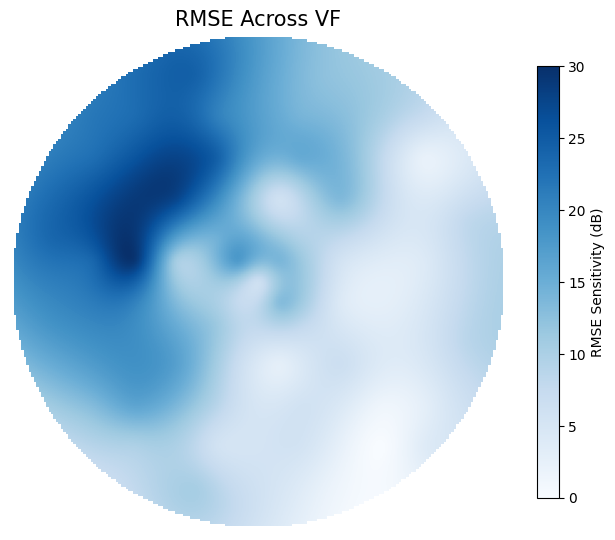

In [72]:
# Total aggregate RMSE across all 631 samples & predictions
plot_VF_RMSE(interpolated_rmse_per_point, cmap='Blues')

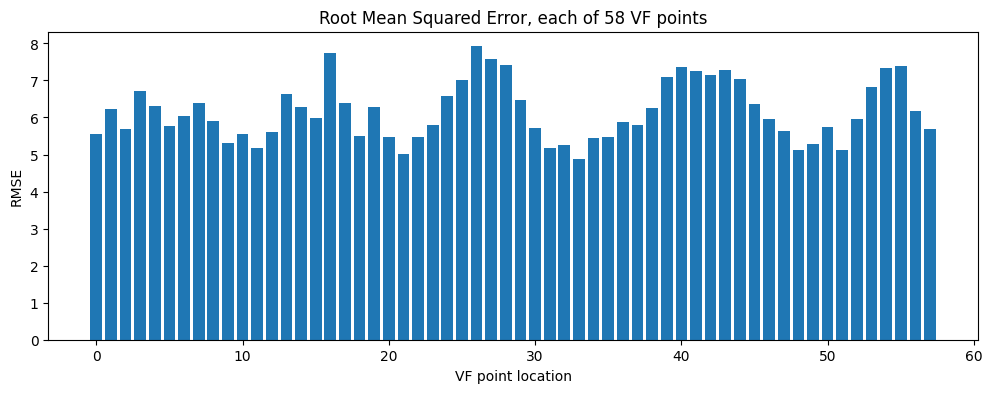

In [84]:
# Look at RMSE for each VF point
plt.figure(figsize=(12,4))
plt.bar(range(len(rmse_per_point)), rmse_per_point)
plt.xlabel("VF point location")
plt.ylabel("RMSE")
plt.title("Root Mean Squared Error, each of 58 VF points")
plt.show()

In [73]:
# Examine predicted output for one patient/visit
# Subject 1, Visit 1
subject1_visit1_diff = pred_db[0] - true_db[0]
subject1_visit1_true = true_db[0]
subject1_visit1_pred = pred_db[0]

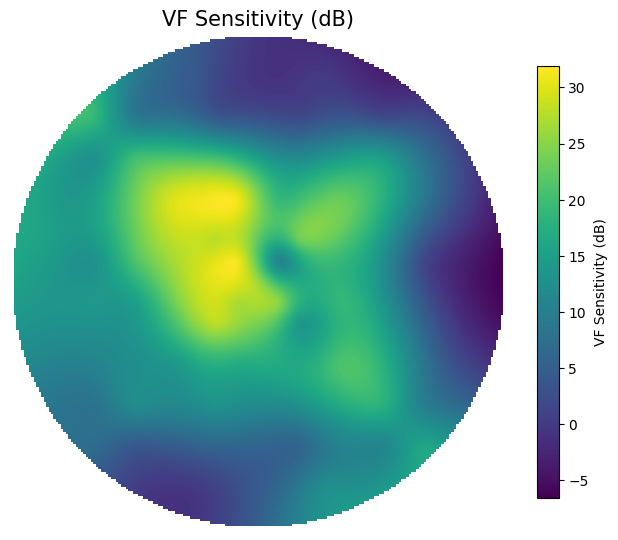

In [81]:
# VF Sensitivity (dB), true, no blind spots, sample subject
# Subject 1, Visit 1
subject1_visit1_true_interp = interpolate_VF_array_no_blindspot(subject1_visit1_true)
plot_VF_original(subject1_visit1_true_interp, cmap="viridis")

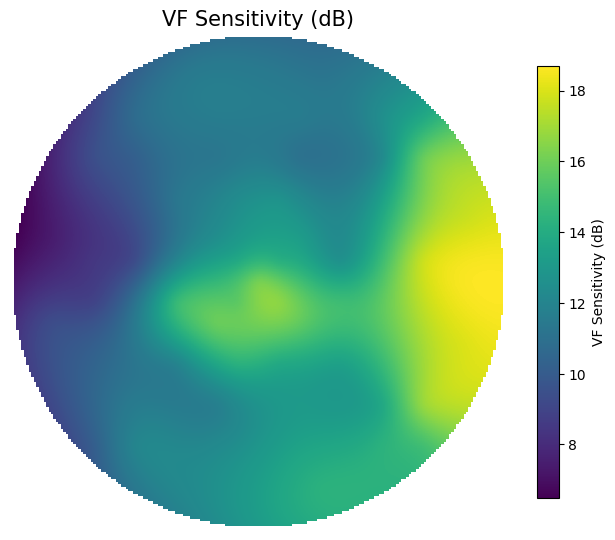

In [82]:
# VF Sensitivity (dB), predicted, no blind spots, sample subject
# Subject 1, Visit 1
subject1_visit1_pred_interp = interpolate_VF_array_no_blindspot(subject1_visit1_pred)
plot_VF_original(subject1_visit1_pred_interp, cmap="viridis")

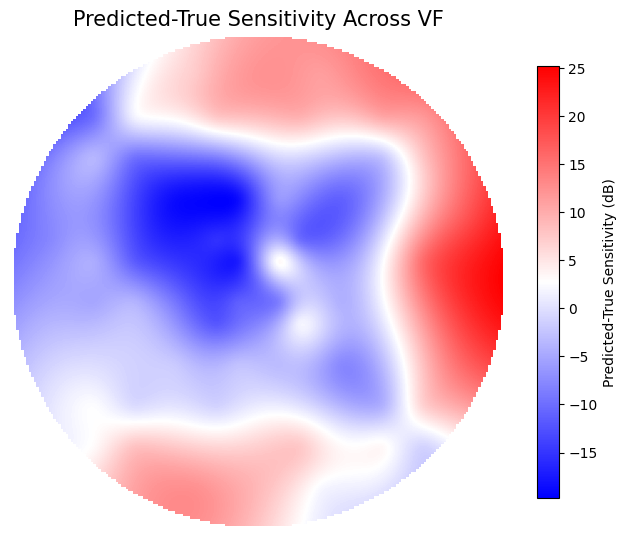

In [76]:
# Predicted - True Sensitivity (Absolute dB) for sample subject
# Subject 1, Visit 1
subject1_visit1_pred_minus_true_interp = interpolate_VF_array_no_blindspot(subject1_visit1_diff)
plot_VF_diff(subject1_visit1_pred_minus_true_interp, cmap="bwr")

In [78]:
global_rmse = np.sqrt(np.mean((true_db - pred_db)**2))
global_rmse

6.213768

In [79]:
# Mean Deviation per sample
true_md = np.mean(true_db, axis=1)    # shape: [N]
pred_md = np.mean(pred_db, axis=1)    # shape: [N]

# MD error per sample
md_error = pred_md - true_md

# Summary statistics
md_mae  = np.mean(np.abs(md_error))
md_rmse = np.sqrt(np.mean(md_error**2))

print(f"MD MAE  (dB): {md_mae:.2f}")
print(f"MD RMSE (dB): {md_rmse:.2f}")

MD MAE  (dB): 2.84
MD RMSE (dB): 3.73


### Archived preliminary CNN activities

### Pilot CNNs + 60 targets
#### Below are the first CNN drafts/explorations
In the very first pass, we focused on training & validation loss across 10 epochs.
In the subsequent pass, we used 20 epochs with the capacity for premature stopping using "patience".

In [ ]:
# Overall CNN: First iteration

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

optimizer = optim.Adam(net.parameters(), lr = 0.0001)

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 256, kernel_size = 3)
        self.pool1 = nn.MaxPool2d(2,2)  # Takes max value from kernel window

        self.conv2 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3)
        self.pool2 = nn.MaxPool2d(2,2)  # Takes max value from kernel window

        self.conv3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 2)
        self.pool3 = nn.AdaptiveAvgPool2d((4,4))
        #self.pool3 = nn.MaxPool2d(2,2)  # Takes max value from kernel window

        self.flatten = nn.Flatten()

        # standard fully connected layers
        self.fc1 = nn.Linear(1024*4*4, 1024)
        #self.fc1 = nn.Linear(in_features = 4096, out_features = 1024)
        self.drop1 = nn.Dropout(p=0.3)

        # standard fully connected layers
        self.fc2 = nn.Linear(in_features = 1024, out_features = 1024)
        self.drop2 = nn.Dropout(p=0.3)

        # ouput layer
        self.out = nn.Linear(in_features = 1024, out_features = 60)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        x = self.out(x)
        
        return x

# Prepare to transform ROI images by cropping and normalizing RGB values to ImageNet dataset statistics (mean, std)
def tensor_transform(image):
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]]))  # resize & transform jpg to tensor, use stats from ImageNet dataset
    img = Image.open(image) 
    tensor_image = transform(img)
    return tensor_image


# Instantiate NeuralNet as net
net = NeuralNet()

# loss function: mean squared error (MSE)
criterion = nn.MSELoss() 

def train_one_epoch():
    net.train(True)  # training mode
    running_loss = 0.0

    for batch_index, data in enumerate(trainloader):
        inputs,labels = data[0], data[1]  # data = (image, label)
        labels = labels.float()
        
        optimizer.zero_grad()  # reset the gradients

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_index % 500 == 499:
            avg_loss_across_batches = running_loss / 500
            print(f"Batch {batch_index+1}, loss = {avg_loss_across_batches}")

            running_loss = 0.0

def validate_one_epoch():
    net.train(False)  # validation mode
    running_loss = 0.0

    for batch_index, data in enumerate(valloader):
        inputs,labels = data[0], data[1]  # data = (image, label)
        labels = labels.float()
    
        with torch.no_grad():
            outputs = net(inputs)  # (batch_size, 60)
            loss = criterion(outputs, labels)  # MSELoss or L1Loss
            running_loss += loss.item()
        
        avg_loss_across_batches = running_loss / len(valloader)
        print(f"Validation loss = {avg_loss_across_batches}")

# Prepare dataset
scaler = StandardScaler()
dataset = []
cols = ['IOP', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
'10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
'22', '23', '24', '25', '26', '28', '29', '30', '31', '32', '33',
'34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
'46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57',
'58', '59']  # remove index 27, (-1) <-- this turned out to be mistaken, should have been 21 and 32, updated in final runs

scaler.fit_transform(GRAPE_followup_df_images[cols].values)

for index, row in GRAPE_followup_df_images.iterrows():
    tensor_image = tensor_transform(row["Corresponding CFP"])
    feature_vector = row[cols].values.reshape(1, -1)
    feature_vector_scaled = scaler.transform(feature_vector)
    tensor_feature_vector_scaled = torch.from_numpy(feature_vector_scaled).float().squeeze(0)
    dataset.append((tensor_image, tensor_feature_vector_scaled))

# dataset is a list of (img_tensor, feature_tensor)
images  = torch.stack([item[0] for item in dataset])
targets = torch.stack([item[1] for item in dataset])

full_dataset = TensorDataset(images, targets)

# 80:20 train/validation split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

trainset, valset = random_split(full_dataset, [train_size, val_size])

batch_size = 8

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size)

# training loop
num_epochs = 10
for epoch_index in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()


In [ ]:
# Overall CNN (2nd iteration)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import numpy as np

# 1. Define CNN
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers: extract local spatial patterns
        # convolution layer 1: lines, edges, simpler textures
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3)  # in_channels, out_channels, kernel size (3x3)
        self.pool1 = nn.MaxPool2d(2,2)  # max pooling layer; reduce spatial size of feature maps by 1/2: (kernel_size, stride)

        # convolution layer 2: more complex patterns
        self.conv2 = nn.Conv2d(256, 512, kernel_size=3)  # increase out_channels to 512 to accommodate more complex features
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(512, 512, kernel_size=2)  # capture finer-grained detail in feature maps
        self.pool3 = nn.AdaptiveAvgPool2d((4,4))  # average pooling layer (take average instead of max value); apparently better for regression tasks

        self.flatten = nn.Flatten()  # convert 2D tensor to 1D tensor

        # Fully connected (dense) layers: learn relationships among features
        # Dense layer 1: 
        self.fc1 = nn.Linear(512*4*4, 1024)  # out_features, in_features: 1024 neurons are going to learn weighted combination of 512x4x4 features
        self.drop1 = nn.Dropout(p=0.5)  # set random 50% of neurons to 0 in each training iterations

        self.fc2 = nn.Linear(1024, 1024)
        self.drop2 = nn.Dropout(p=0.5)

        # Output layer: map learned features to 60 predictions
        self.out = nn.Linear(1024, 60)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        x = self.out(x)
        
        return x

# 2. Image transformation function (with augmentation across training epochs) <-- note, dropped augmentation in final runs
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

def tensor_transform(image_path):
    img = Image.open(image_path).convert('RGB')
    return transform(img)

# 3. Prepare dataset
scaler_y = StandardScaler()

cols = ['IOP','0','1','2','3','4','5','6','7','8','9',
        '10','11','12','13','14','15','16','17','18','19','20','21',
        '22','23','24','25','26','28','29','30','31','32','33',
        '34','35','36','37','38','39','40','41','42','43','44','45',
        '46','47','48','49','50','51','52','53','54','55','56','57',
        '58','59']

targets_scaled = scaler_y.fit_transform(GRAPE_followup_df_images[cols].values)  # scale target values

# prepare dataset: list of (img_tensor, feature_tensor) tuples
dataset = []
for index, row in GRAPE_followup_df_images.iterrows():
    img_tensor = tensor_transform(row["Corresponding CFP"])
    target_tensor = torch.from_numpy(targets_scaled[index]).float()
    dataset.append((img_tensor, target_tensor))

images = torch.stack([item[0] for item in dataset])
targets = torch.stack([item[1] for item in dataset])

full_dataset = TensorDataset(images, targets)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
trainset, valset = random_split(full_dataset, [train_size, val_size]) # [train_size, val_size] = how many samples go into each split

batch_size = 8
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)  # shuffle=True -> random image order during each training epoch
valloader = DataLoader(valset, batch_size=batch_size)

# 4. Training setup
net = NeuralNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
# reduce learning rate across epochs if loss stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)  

# 5. Training / validation functions
def train_one_epoch():
    net.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        labels = labels.float()
        optimizer.zero_grad()  # clear out gradients stored from previous batch iterations

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)  # weight by batch size (inputs.size(0))

    avg_loss = running_loss / len(trainloader.dataset)
    print(f"Train loss: {avg_loss}")
    return avg_loss

def validate_one_epoch():
    net.eval()
    running_loss = 0.0

    with torch.no_grad():  # validation doesn't need weight updates; inactivate gradient tracking and updating
        for inputs, labels in valloader:
            labels = labels.float()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

    avg_loss = running_loss / len(valloader.dataset)
    print(f"Validation loss: {avg_loss:.4f}")
    return avg_loss

# 6. Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch()
    val_loss = validate_one_epoch()

    scheduler.step(val_loss)  # adjust LR if plateau

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


In [ ]:
# predictions on validation set
net.eval()
all_preds = []
all_trues = []

with torch.no_grad():
    for x, y in valloader:
        pred = net(x).cpu().numpy()
        all_preds.append(pred)
        all_trues.append(y.numpy())

all_preds = np.vstack(all_preds)
all_trues = np.vstack(all_trues)

### things to consider doing next with target predictions:  
- plot error loss over epochs
- plot subset of filter outputs for representative image (e.g., 16 filters)
- use actual mean, std of image set instead of stock mean, std

Evaluation:  
- plot correlation between predicted and ground truth for each target
- calculate RMSE for each target
- calculate mean RMSE across all targets
